In [1]:
import os
import datetime
import requests

import pandas as pd
import geopandas as gpd
import shapely

import pyrosm
import r5py
import gtfs_kit as gk

from common_functions import setup_folders, generate_points_on_land, download_transitland_feeds_for_area, download_topography, scatter_plot, set_modules_to_autoreload

set_modules_to_autoreload()

parent_folder = "downloaded data/new_york_travel_times"
setup_folders(parent_folder, ['osm', 'gtfs', 'topography'])

In [5]:
print(pyrosm.data.sources.cities.available)

['Aachen', 'Aarhus', 'Adelaide', 'Albuquerque', 'Alexandria', 'Amsterdam', 'Antwerpen', 'Arnhem', 'Auckland', 'Augsburg', 'Austin', 'Baghdad', 'Baku', 'Balaton', 'Bamberg', 'Bangkok', 'Barcelona', 'Basel', 'Beijing', 'Beirut', 'Berkeley', 'Berlin', 'Bern', 'Bielefeld', 'Birmingham', 'Bochum', 'Bogota', 'Bombay', 'Bonn', 'Bordeaux', 'Boulder', 'BrandenburgHavel', 'Braunschweig', 'Bremen', 'Bremerhaven', 'Brisbane', 'Bristol', 'Brno', 'Bruegge', 'Bruessel', 'Budapest', 'BuenosAires', 'Cairo', 'Calgary', 'Cambridge', 'CambridgeMa', 'Canberra', 'CapeTown', 'Chemnitz', 'Chicago', 'ClermontFerrand', 'Colmar', 'Copenhagen', 'Cork', 'Corsica', 'Corvallis', 'Cottbus', 'Cracow', 'CraterLake', 'Curitiba', 'Cusco', 'Dallas', 'Darmstadt', 'Davis', 'DenHaag', 'Denver', 'Dessau', 'Dortmund', 'Dresden', 'Dublin', 'Duesseldorf', 'Duisburg', 'Edinburgh', 'Eindhoven', 'Emden', 'Erfurt', 'Erlangen', 'Eugene', 'Flensburg', 'FortCollins', 'Frankfurt', 'FrankfurtOder', 'Freiburg', 'Gdansk', 'Genf', 'Gent', '

In [10]:
city_name = "NewYorkCity"

travel_date = "2026-01-05"

city_name = "NewYorkCity"

destinations = gpd.GeoDataFrame(
    {
        "id": ["times square"],
        "geometry": [shapely.Point((40.75600719845023, -73.98701163570061)[::-1])]
    },
    crs="EPSG:4326",
)

In [9]:
#download osm data using pyrosm and save to vancouver-travel-times/osm/

osm = pyrosm.get_data(city_name, directory=f"{parent_folder}/osm/")

Downloaded Protobuf data 'newyorkcity.osm.pbf' (142.38 MB) to:
'c:\Users\marki\Github\osm-sketches\downloaded data\new_york_travel_times\osm\newyorkcity.osm.pbf'


In [11]:
# Initialize the OSM object 
osm = pyrosm.OSM(parent_folder + f"/osm/{city_name}.osm.pbf")

In [16]:
"""#get the bounding box of the osm data
drive_net = osm.get_network(network_type="driving")
bbox = drive_net.total_bounds  # minx, miny, maxx, maxy
print("OSM data bounding box:", bbox)

p1, p2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
"""
p1, p2 = (40.68809513646478, -74.04947253183217)[::-1], (40.82771349291664, -73.81725385346202)[::-1]

Centroid: [-73.93336319264709, 40.757904314690705]
Estimated UTM CRS: EPSG:32618
Number of points in x direction: 26
Number of points in y direction: 21
Generated 546 grid points.
Centroid: [np.float64(-73.93314076906526), np.float64(40.75784874723631)]
Estimated UTM CRS: EPSG:32618
                         geometry
0  POINT (580303.585 4504318.661)
1  POINT (599780.787 4520542.466)
Aspect ratio (height/width): 0.8329638211861095


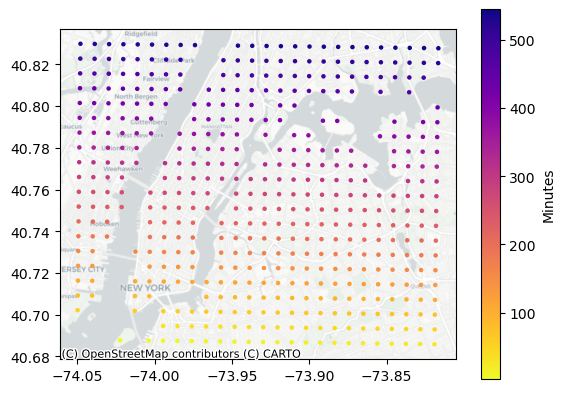

In [18]:
grid_points, land = generate_points_on_land(p1, p2, spacing=750)

scatter_plot(grid_points.geometry.x, grid_points.geometry.y, grid_points.id)

In [19]:
download_transitland_feeds_for_area(p1, p2, travel_date, parent_folder + "/gtfs")

17 unique feeds found in area.
Checking archive for f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle
Download feed for agency f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle. Date range: 2025-12-28 00:00:00 to 2026-12-28 00:00:00
Checking archive for f-r6-nswtrainlink~sydneytrains~buswayswesternsydney~interlinebus
Download feed for agency f-r6-nswtrainlink~sydneytrains~buswayswesternsydney~interlinebus. Date range: 2026-01-04 00:00:00 to 2026-04-04 00:00:00
Checking archive for f-adirondack~trailways~adt
Download feed for agency f-adirondack~trailways~adt. Date range: 2026-01-01 00:00:00 to 2026-06-16 00:00:00
Checking archive for f-9-flixbus
Download feed for agency f-9-flixbus. Date range: 2026-01-04 00:00:00 to 2026-07-03 00:00:00
Checking archive for f-adirondack~trailways~phk
Download feed for agency f-adirondack~trailways~phk. Date range: 2025-09-04 00:00:00 to 2026-01-06 00:00:00
Checking archive for f-dr5r-nycferry
Download feed for agency f-dr5r-nycferry. Date range: 2026

In [20]:
#additional data cleaning for GTFS

gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")]    

#Some trips have arrival or departure times > 72:00:00 hours which r5py cannot handle. Find these trips and remove them from the feed, re-saving the feed to a .zip file

for path in gtfs_paths:
    feed = gk.read_feed(path, dist_units="km")

    #check if any stop_times have arrival or departure times higher than 72:00:00 hours
    max_seconds = 72 * 3600
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time).dt.total_seconds()
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time).dt.total_seconds()

    offending_trips = feed.stop_times[(feed.stop_times.departure_time > max_seconds) | (feed.stop_times.arrival_time > max_seconds)].trip_id.unique()

    if len(offending_trips) == 0:
        print("{} trips in feed {} have arrival/departure times > 72 hours. No pruning needed.".format(len(offending_trips), path))
        continue

    print("{} trips in feed {} have arrival/departure times > 72 hours. Pruning trips.".format(len(offending_trips), path))
    #delete offending trips from feed
    feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(offending_trips)]

    #convert back to hh:mm:ss format. Format as string
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    #save modified feed back to zip file
    feed.to_file(path)
    
#check for shapes with only one point. Remove them, and find trips that use those shapes and remove them too
for path in gtfs_paths:
    feed = gk.read_feed(path, dist_units="km")

    if feed.shapes is None or feed.shapes.empty:
        #delete feed zip from folder if no shapes present
        print("No shapes found in feed {}. Deleting feed.".format(path))
        os.remove(path)
        continue

    shape_lengths = feed.shapes.groupby('shape_id').size()
    single_point_shapes = shape_lengths[shape_lengths == 1].index.tolist()

    if len(single_point_shapes) == 0:
        print("No single-point shapes found in feed {}".format(path))
        continue

    print("Found {} single-point shapes in feed {}. Pruning shapes and associated trips.".format(len(single_point_shapes), path))
    print("Single-point shape IDs:", single_point_shapes)
    print("Affected trip IDs:", feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique().tolist())

    #remove single-point shapes
    feed.shapes = feed.shapes[~feed.shapes.shape_id.isin(single_point_shapes)]
    #remove trips that use those shapes
    feed.trips = feed.trips[~feed.trips.shape_id.isin(single_point_shapes)]
    #remove stop_times for those trips
    feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique())]

    #save modified feed back to zip file
    feed.to_file(path)


4 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle.zip have arrival/departure times > 72 hours. Pruning trips.
0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-9-flixbus.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~adt.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~nyt.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~phk.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5-mtanyclirr.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed downloaded data/new_yor

c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


0 trips in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-r6-nswtrainlink~sydneytrains~buswayswesternsydney~interlinebus.zip have arrival/departure times > 72 hours. No pruning needed.
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle.zip
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-9-flixbus.zip
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~adt.zip
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~nyt.zip
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-adirondack~trailways~phk.zip
No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5-mtanyclirr.zip
No single-point shapes found in feed downloaded data/new_york_travel_t

c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_kit\feed.py:392: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


No single-point shapes found in feed downloaded data/new_york_travel_times/gtfs/2026-01-05_f-r6-nswtrainlink~sydneytrains~buswayswesternsydney~interlinebus.zip


In [21]:
download_topography(p1, p2, parent_folder)

Topography data downloaded successfully.


In [28]:
gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")
              ]

print(gtfs_paths)
transport_network = r5py.TransportNetwork(
    osm_pbf = parent_folder + f"/osm/{city_name}.osm.pbf",
    gtfs = gtfs_paths,
    elevation_model = parent_folder + "/topography/topography-wgs.tif"

)

['downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5-mtanyclirr.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5-nj~transit~bus.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5-nj~transit~rail.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5r-mtabc.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5r-mtanyctbusbrooklyn.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5r-mtanyctbusmanhattan.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5r-mtanyctbusstatenisland.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5r-nycferry.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr5x-mtanyctbusqueens.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr7-mtanyc~metro~north.zip', 'downloaded data/new_york_travel_times/gtfs/2026-01-05_f-dr72-mtanyctbusbronx.zip']


In [ ]:
origins = grid_points.copy().reset_index(drop=True)
origins.geometry = origins.geometry.centroid

transit_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
        r5py.TransportMode.WALK
    ],
    snap_to_network=False,
)

bike_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.BICYCLE,
    ],
    snap_to_network=False,
    speed_cycling = 21.5,
    speed_walking = 6.0,
)

C:\Users\marki\AppData\Local\Temp\ipykernel_4060\1552374191.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.geometry = origins.geometry.centroid


In [30]:
travel_times = origins.copy()

travel_times['transit'] = transit_travel_times.travel_time
travel_times['bike'] = bike_travel_times.travel_time

travel_date

travel_times = travel_times.dropna()

print(f"{len(travel_times)} rows with complete travel time data.")

414 rows with complete travel time data.


Centroid: [np.float64(-73.93316534668175), np.float64(40.75773241379563)]
Estimated UTM CRS: EPSG:32618
                         geometry
0  POINT (580354.778 4505106.656)
1  POINT (599728.032 4519728.401)
Aspect ratio (height/width): 0.754738706648043


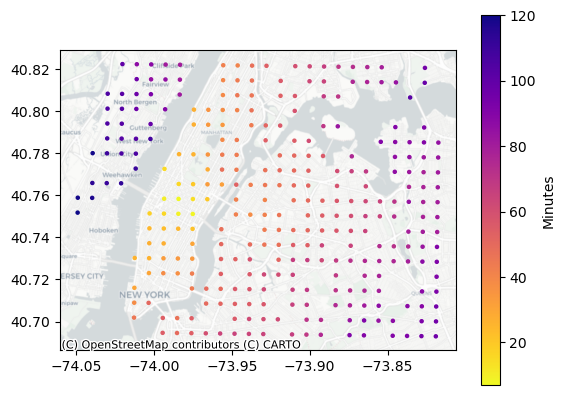

In [50]:
#Take a sample of travel time data for google maps calibration
sample = travel_times.sample(300, random_state=1)
sample['sample_id'] = range(len(sample))

scatter_plot(
    sample.geometry.x,
    sample.geometry.y,
    sample.bike)

In [51]:
#calibration of cycling times against Google Maps API

MAPS_API_KEY = os.getenv("MAPS_PLATFORM_API_KEY")

# Google Maps Route Matrix API request - multiple origins to one destination
url = "https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix"

# Convert sample points to proper API structure
origins_list = [
    {
        "waypoint": {
            "location": {
                "latLng": {
                    "latitude": lat,
                    "longitude": lon
                }
            }
        }
    }
    for lon, lat in zip(sample.geometry.x, sample.geometry.y)
]

# Destination
destination = destinations.iloc[0]
destinations_list = [
    {
        "waypoint": {
            "location": {
                "latLng": {
                    "latitude": destination.geometry.y,
                    "longitude": destination.geometry.x
                }
            }
        }
    }
]

payload = {
    "origins": origins_list,
    "destinations": destinations_list,
    "travelMode": "BICYCLE"
}

headers = {
    "Content-Type": "application/json",
    "X-Goog-Api-Key": MAPS_API_KEY,
    "X-Goog-FieldMask": "originIndex,destinationIndex,duration,distanceMeters,status,condition"
}

response = requests.post(url, json=payload, headers=headers)
results = response.json()

results

[{'originIndex': 282,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 6292,
  'duration': '1618s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 296,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 768,
  'duration': '409s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 297,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 11057,
  'duration': '2657s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 289,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 3410,
  'duration': '705s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 2,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 2422,
  'duration': '804s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 295,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 5587,
  'duration': '1252s',
  'condition': 'ROUTE_EXISTS'},
 {'originIndex': 279,
  'destinationIndex': 0,
  'status': {},
  'distanceMeters': 6135,
  'duration': '1396s',
  'condition': 'ROUTE_EXISTS'

In [60]:
gmaps_df = pd.DataFrame(columns=["origin_id", "destination_id", "route_exists", "gmaps_travel_time", "distance"])

for result in results:
    new_row = {
        'origin_id': result['originIndex'],
        'destination_id': result['destinationIndex'],
        'route_exists': (result['condition'] == 'ROUTE_EXISTS'),
        'gmaps_travel_time': int(result['duration'].replace('s',''))/60 if result['condition'] == 'ROUTE_EXISTS' else None,
        'distance': result['distanceMeters'] if result['condition'] == 'ROUTE_EXISTS' else None
    }

    gmaps_df = pd.concat([gmaps_df, pd.DataFrame([new_row])], ignore_index=True)

comparison = sample.merge(gmaps_df, left_on = 'sample_id', right_on = 'origin_id')

C:\Users\marki\AppData\Local\Temp\ipykernel_4060\3482606344.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gmaps_df = pd.concat([gmaps_df, pd.DataFrame([new_row])], ignore_index=True)


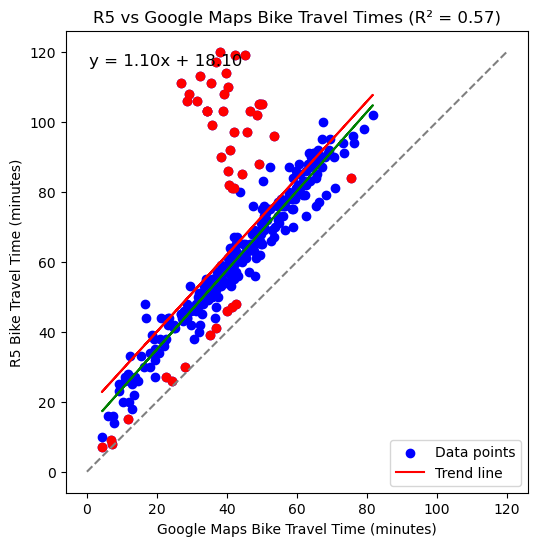

In [67]:
#plot comparison.gmaps_travel_time vs comparison.bike with matplotlib, compute regession, and show trend line and R2 value

#trim comparison - delete anything with gmaps travel time over 80 minutes
comparison = comparison[comparison.gmaps_travel_time <= 100]
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(comparison.gmaps_travel_time, comparison.bike, color='blue', label='Data points')
#compute regression
from sklearn.linear_model import LinearRegression
import numpy as np
X = comparison.gmaps_travel_time.values.reshape(-1, 1)
y = comparison.bike.values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
plt.plot(comparison.gmaps_travel_time, y_pred, color='red', label='Trend line')
r2 = reg.score(X, y)

eqn_label = f'y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}'
plt.text(0.05, 0.95, eqn_label, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Google Maps Bike Travel Time (minutes)')
plt.ylabel('R5 Bike Travel Time (minutes)')
plt.title(f'R5 vs Google Maps Bike Travel Times (R² = {r2:.2f})')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')

#also add a y = x line for reference, in grey
max_time = max(comparison.gmaps_travel_time.max(), comparison.bike.max())
plt.plot([0, max_time], [0, max_time], color='grey', linestyle
='--', label='y = x')

#figure out points that difer from the trend line by more than 10 minutes
difference = np.abs(comparison.bike - y_pred)
outliers = comparison[difference > 15]

plt.scatter(outliers.gmaps_travel_time, outliers.bike, color='red', label='Outliers (>10 min difference)')

#delete outliers from comparison dataframe and recompute regression without them
comparison_no_outliers = comparison[difference <= 15]
X_no_outliers = comparison_no_outliers.gmaps_travel_time.values.reshape(-1,
    1)
y_no_outliers = comparison_no_outliers.bike.values
reg_no_outliers = LinearRegression().fit(X_no_outliers, y_no_outliers)
y_pred_no_outliers = reg_no_outliers.predict(X_no_outliers)
plt.plot(comparison_no_outliers.gmaps_travel_time, y_pred_no_outliers,
    color='green', label='Trend line (no outliers)')
plt.show()

In [68]:
#adjust the bike travel times based on the regression (note that originally, the regression had gmaps on the X axis and r5 on the Y axis)

travel_times['adjusted bike'] = travel_times['bike'] / reg_no_outliers.coef_[0] - reg_no_outliers.intercept_
travel_times['delta'] = travel_times.transit - travel_times['adjusted bike']

In [ ]:
#get detailed route itenary for (40.7616291743126, -73.83090061699174) to destination

origins = gpd.GeoDataFrame(
    {
        "id": ["flushing"],
        "geometry": [shapely.Point((40.7616291743126, -73.83090061699174)[::-1])],
    },
    crs="EPSG:4326"
)

detailed_itineraries = r5py.DetailedItineraries(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
    ],
    snap_to_network=False,
)

In [105]:
detailed_itineraries

summary = detailed_itineraries.groupby('option')['travel_time'].sum()

summary

print("Option 0")
route = detailed_itineraries[detailed_itineraries['option'] == 0]

route['route_name'] = None
for i, row in route.iterrows():
    feed_name = row['feed']

    if feed_name is None:
        continue
    print(feed_name)
    #read the feed
    feed = gk.read_feed(parent_folder + "/gtfs/" + feed_name + ".zip", dist_units="km")

    routes = feed.routes

    #get route_short_name for route_id
    route['route_name'].iloc[i] = routes[routes.route_id == row['route_id']].route_long_name.values[0]

routes

Option 0
2026-01-05_f-dr5-mtanyclirr


c:\Users\marki\anaconda3\envs\geo\lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\marki\AppData\Local\Temp\ipykernel_4060\3933170869.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.l

2026-01-05_f-dr5-mtanyclirr


C:\Users\marki\AppData\Local\Temp\ipykernel_4060\3933170869.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  route['route_name'].iloc[i] = routes[routes.route_id == row['route_id']].route_long_name.values[0]
C:\Users\marki\AppData\Local\

2026-01-05_f-dr5r-mtanyctbusmanhattan


C:\Users\marki\AppData\Local\Temp\ipykernel_4060\3933170869.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  route['route_name'].iloc[i] = routes[routes.route_id == row['route_id']].route_long_name.values[0]
C:\Users\marki\AppData\Local\

,from_id,to_id,option,segment,transport_mode,departure_time,distance,travel_time,wait_time,feed,agency_id,route_id,start_stop_id,end_stop_id,geometry,route_name
0,flushing,times square,0,0,TransportMode.WALK,2026-01-05 07:36:26,555.166000,0 days 00:10:44,0 days 00:00:00,None,None,None,None,None,"LINESTRING (-73.8304 40.76171, -73.83101 40.76...",None
1,flushing,times square,0,1,TransportMode.RAIL,2026-01-05 07:51:00,6913.471455,0 days 00:10:00,0 days 00:07:12,2026-01-05_f-dr5-mtanyclirr,LI,9,56,214,"LINESTRING (-73.83135 40.75791, -73.83186 40.7...",Port Washington Branch
2,flushing,times square,0,2,TransportMode.RAIL,2026-01-05 08:04:00,7304.266903,0 days 00:12:00,0 days 00:03:00,2026-01-05_f-dr5-mtanyclirr,LI,1,214,349,"LINESTRING (-73.90299 40.74581, -73.90334 40.7...",Babylon Branch
3,flushing,times square,0,3,TransportMode.WALK,2026-01-05 08:17:00,445.403000,0 days 00:07:51,0 days 00:00:37,None,None,None,None,None,"LINESTRING (-73.97531 40.75522, -73.97533 40.7...",None
4,flushing,times square,0,4,TransportMode.BUS,2026-01-05 08:28:00,655.672999,0 days 00:04:07,0 days 00:04:32,2026-01-05_f-dr5r-mtanyctbusmanhattan,MTA NYCT,M42,405241,403830,"LINESTRING (-73.97749 40.75208, -73.9775 40.75...",United Nations - W 42 St Pier
5,flushing,times square,0,5,TransportMode.WALK,2026-01-05 08:33:07,289.502000,0 days 00:05:05,0 days 00:00:00,None,None,None,None,None,"LINESTRING (-73.98428 40.75499, -73.98427 40.7...",None


369
X limits: (np.float64(-8243092.175890643), np.float64(-8217312.462364379))
Y limits: (np.float64(4967155.889117046), np.float64(4986198.7055822015))
X limits: (np.float64(-8243092.175890643), np.float64(-8217312.462364379))
Y limits: (np.float64(4967155.889117046), np.float64(4986198.7055822015))
X limits: (np.float64(-8243092.175890643), np.float64(-8217312.462364379))
Y limits: (np.float64(4967155.889117046), np.float64(4986198.7055822015))


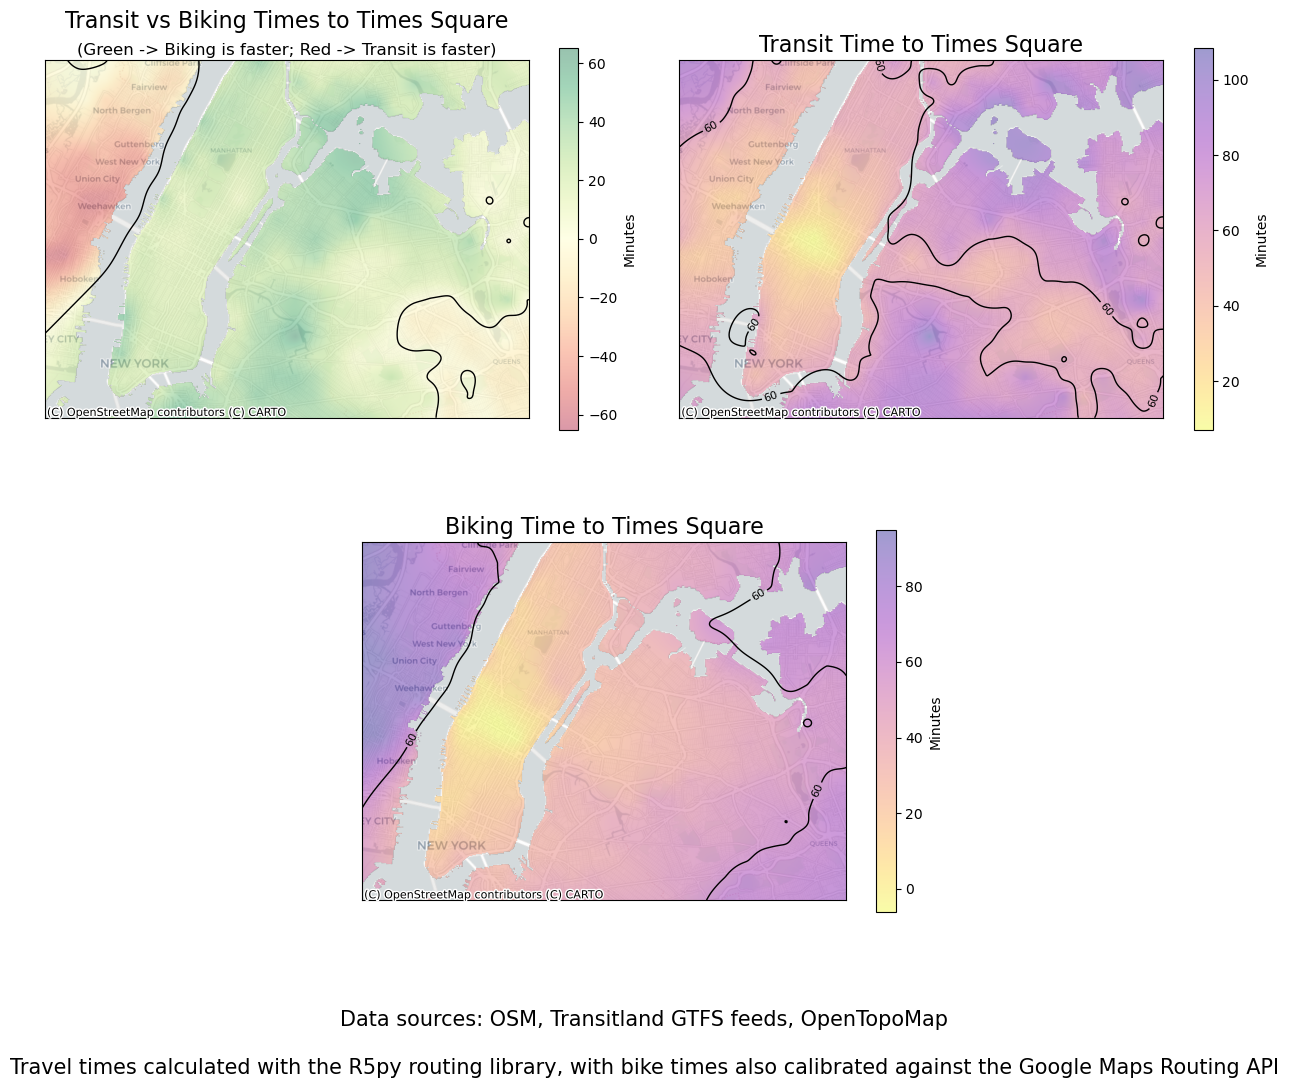

In [69]:
import matplotlib.pyplot as plt
from common_functions import plot_interpolated_grid

#p3 = (49.25676113415463, -123.17739582109954)[::-1]
#p4 = (49.19733762312748, -123.06635611804826)[::-1]

p3 = p1
p4 = p2

#clip travel_times = by p3 and p4
box_gdf = shapely.box(p3[0], p3[1], p4[0], p4[1])
travel_times = travel_times.clip(box_gdf)
travel_times = travel_times.dropna()

print(len(travel_times))

# --- Create the shared figure and axes ---
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 4, hspace=0.01, wspace=0.1, height_ratios=[1, 1], top=0.92, bottom=0.12)

# Create axes with proper centering
ax1 = fig.add_subplot(gs[0, 0:2])  # First plot spans columns 0-1
ax2 = fig.add_subplot(gs[0, 2:4])  # Second plot spans columns 2-3
ax3 = fig.add_subplot(gs[1, 1:3])  # Third plot spans columns 1-2 (centered)

# --- First plot: Transit vs Bike delta ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['delta'],
    land=land,
    contours=[0],
    zero_centred=True,
    grid_size=400,
    cmap='RdYlGn',
    title="Transit vs Biking Times to Times Square",
    sub_title="(Green -> Biking is faster; Red -> Transit is faster)",
    ax=ax1
)

# --- Second plot: Transit time ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['transit'],
    land=land,
    contours=[60],
    zero_centred=False,
    grid_size=400,
    cmap='plasma_r',
    title="Transit Time to Times Square",
    ax=ax2
)

# --- Third plot: Bike time ---
plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['adjusted bike'],
    land=land,
    contours=[60],
    zero_centred=False,
    grid_size=400,
    #additional_gdf=detailed_itineraries,
    cmap='plasma_r',
    title="Biking Time to Times Square",
    ax=ax3
)

#add a note to the bottom of the figure
fig.text(0.5, .065, "Data sources: OSM, Transitland GTFS feeds, OpenTopoMap", ha='center', fontsize=15)

#add a second line to the bottom of the figure
fig.text(0.5, .025, "Travel times calculated with the R5py routing library, with bike times also calibrated against the Google Maps Routing API", ha='center', fontsize=15)

plt.show()